# Quant Project

For being able to mount using Google Colab

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from IPython.display import display
import matplotlib.pyplot as plt
from math import pi

Data Download

Ticker           AAPL       AMZN         GM       GOOG        META  \
Date                                                                 
2020-01-02  72.538521  94.900497  35.701893  67.903816  208.494690   
2020-01-03  71.833298  93.748497  34.689468  67.570595  207.391495   
2020-01-06  72.405685  95.143997  34.231026  69.236702  211.297409   
2020-01-07  72.065147  95.343002  33.572002  69.193489  211.754608   
2020-01-08  73.224403  94.598503  33.094448  69.738770  213.901352   

Ticker            MSFT      NVDA       SONY          TM       TSLA  
Date                                                                
2020-01-02  152.791138  5.971409  13.346421  121.316772  28.684000  
2020-01-03  150.888611  5.875833  13.157030  120.045944  29.534000  
2020-01-06  151.278641  5.900472  13.356085  120.062996  30.102667  
2020-01-07  149.899292  5.971909  13.566736  120.694145  31.270666  
2020-01-08  152.286957  5.983109  13.616986  120.395645  32.809334  


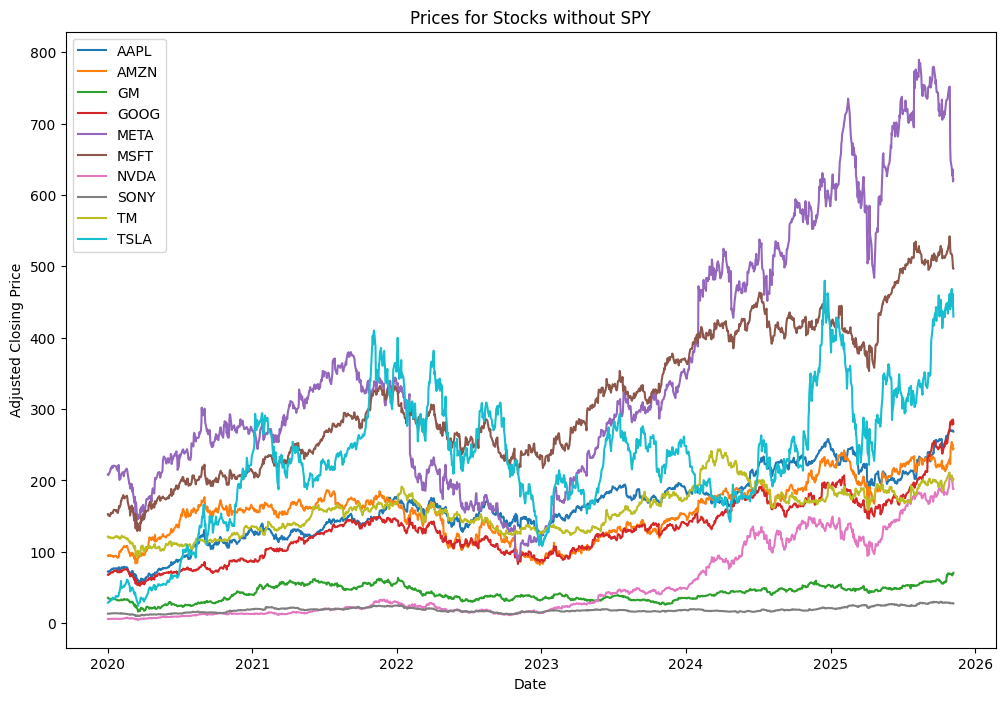

Ticker             SPY
Date                  
2020-01-02  298.578644
2020-01-03  296.317749
2020-01-06  297.448242
2020-01-07  296.611877
2020-01-08  298.192719


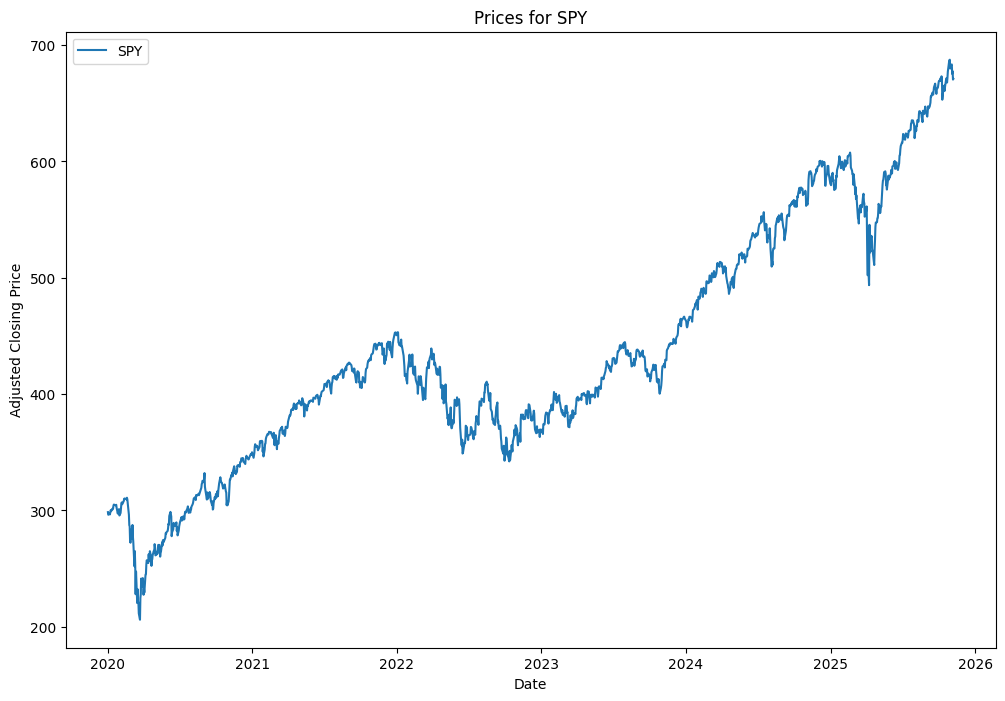

In [19]:
spy_stock = "SPY" #S&P 500 ETF
the_tickers = ["GOOG", "AMZN", "AAPL", "META", "MSFT", "NVDA", "TSLA", "SONY", "GM", "TM"]
all_tickers = [spy_stock] + the_tickers

my_data = yf.download(the_tickers, start="2020-01-01", end=None, progress=False, auto_adjust=True)["Close"]
my_data = my_data.dropna()
print(my_data.head())
plt.figure(figsize=(12, 8))
for ticker in my_data.columns:
    plt.plot(my_data.index, my_data[ticker], label=ticker)
plt.title("Prices for Stocks without SPY")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.legend()
plt.show()

spy_data = yf.download(spy_stock, start="2020-01-01", end=None, progress=False, auto_adjust=True)["Close"]
spy_data = spy_data.dropna()
print(spy_data.head())
plt.figure(figsize=(12, 8))
plt.plot(spy_data.index, spy_data.values, label=spy_stock)
plt.title("Prices for SPY")
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.legend()
plt.show()

Log Returns and Summary Statistics

In [20]:
#Compute log returns for all tickers
log_returns = np.log(my_data / my_data.shift(1)).dropna()
spy_returns = np.log(spy_data / spy_data.shift(1)).dropna()

#Inspect
print("Sample of log returns:")
print(log_returns.head())

#Check shape
print(f"Shape of log_returns: {log_returns.shape}")

summary_stats = pd.DataFrame({
    "Mean": log_returns.mean(),
    "StdDev": log_returns.std(),
    "Skewness": log_returns.skew(),
    "Kurtosis": log_returns.kurt()
}).sort_values("StdDev", ascending=False)

display(summary_stats.style.format("{:.4f}").background_gradient(cmap="coolwarm"))

Sample of log returns:
Ticker          AAPL      AMZN        GM      GOOG      META      MSFT  \
Date                                                                     
2020-01-03 -0.009770 -0.012213 -0.028768 -0.004919 -0.005305 -0.012530   
2020-01-06  0.007937  0.014776 -0.013304  0.024358  0.018658  0.002582   
2020-01-07 -0.004714  0.002089 -0.019440 -0.000624  0.002161 -0.009160   
2020-01-08  0.015958 -0.007839 -0.014327  0.007850  0.010087  0.015803   
2020-01-09  0.021018  0.004788  0.012334  0.010984  0.014210  0.012416   

Ticker          NVDA      SONY        TM      TSLA  
Date                                                
2020-01-03 -0.016135 -0.014292 -0.010531  0.029203  
2020-01-06  0.004185  0.015016  0.000142  0.019072  
2020-01-07  0.012034  0.015649  0.005243  0.038067  
2020-01-08  0.001874  0.003697 -0.002476  0.048033  
2020-01-09  0.010923  0.008057 -0.004616 -0.022189  
Shape of log_returns: (1471, 10)


,Mean,StdDev,Skewness,Kurtosis
Ticker,,,,
TSLA,0.0018,0.0421,-0.0881,3.2814
NVDA,0.0023,0.0336,0.0397,4.0409
META,0.0007,0.0281,-1.0740,21.9042
GM,0.0005,0.0268,-0.1599,5.9789
AMZN,0.0006,0.0226,-0.0700,4.2988
GOOG,0.0010,0.0204,-0.1898,3.7528
AAPL,0.0009,0.0202,0.0266,6.3269
SONY,0.0005,0.0188,0.1081,3.3048
MSFT,0.0008,0.0187,-0.1633,7.8272


Histogram of Returns

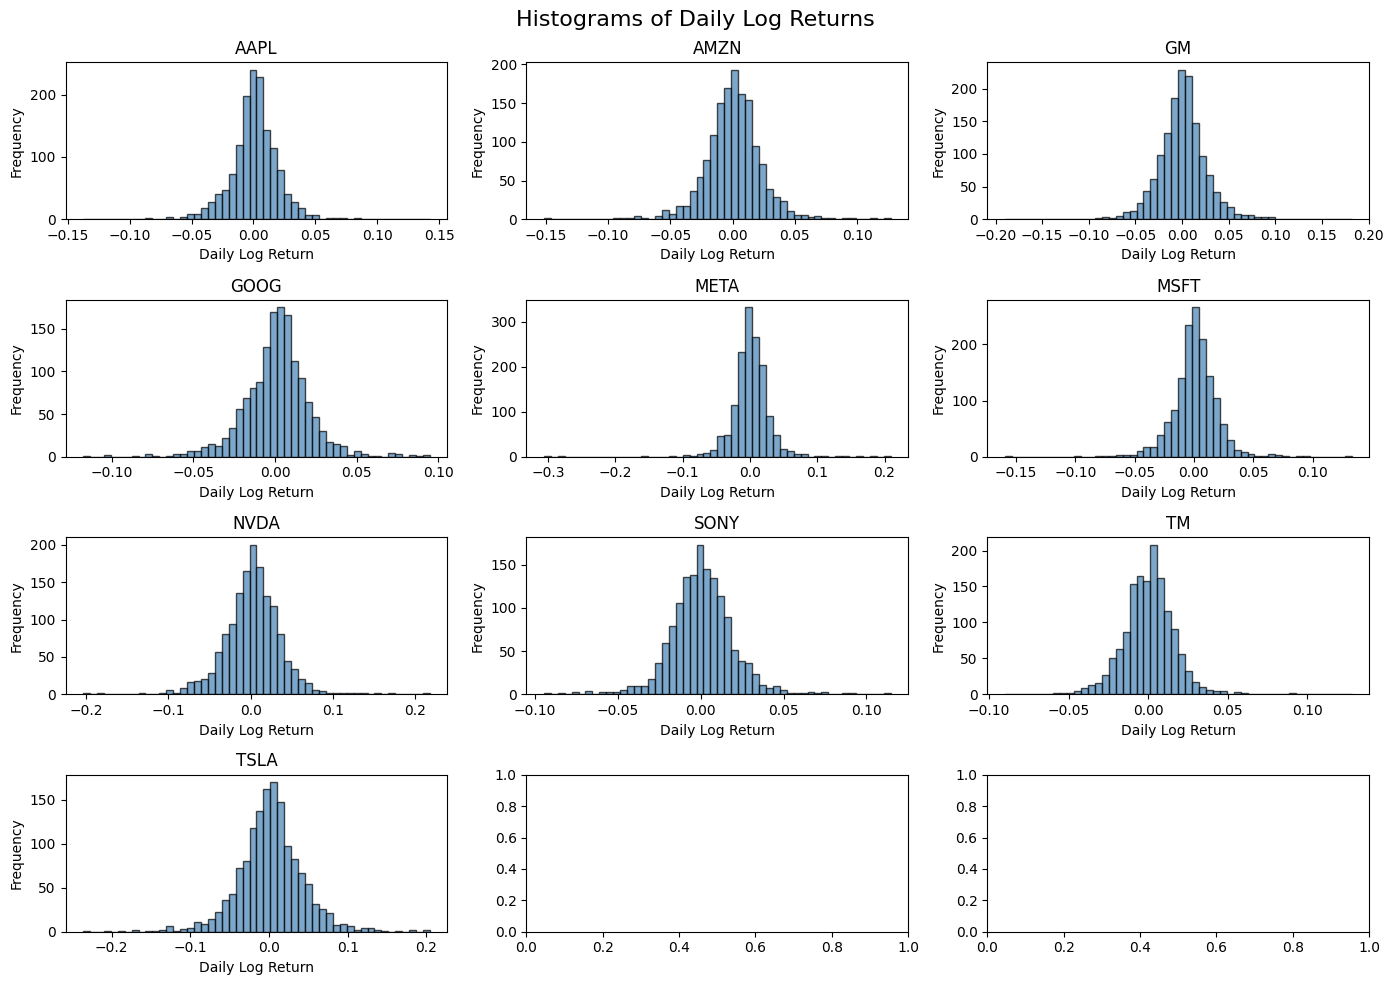

In [21]:
fig, myAxes = plt.subplots(4, 3, figsize=(14,10))
myAxes = myAxes.flatten()

for i, ticker in enumerate(log_returns.columns[:len(myAxes)]):
    myAxes[i].hist(log_returns[ticker], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    myAxes[i].set_title(ticker)
    myAxes[i].set_xlabel("Daily Log Return")
    myAxes[i].set_ylabel("Frequency")

plt.suptitle("Histograms of Daily Log Returns", fontsize=16)
plt.tight_layout()
plt.show()

Compare Volatility with SPY

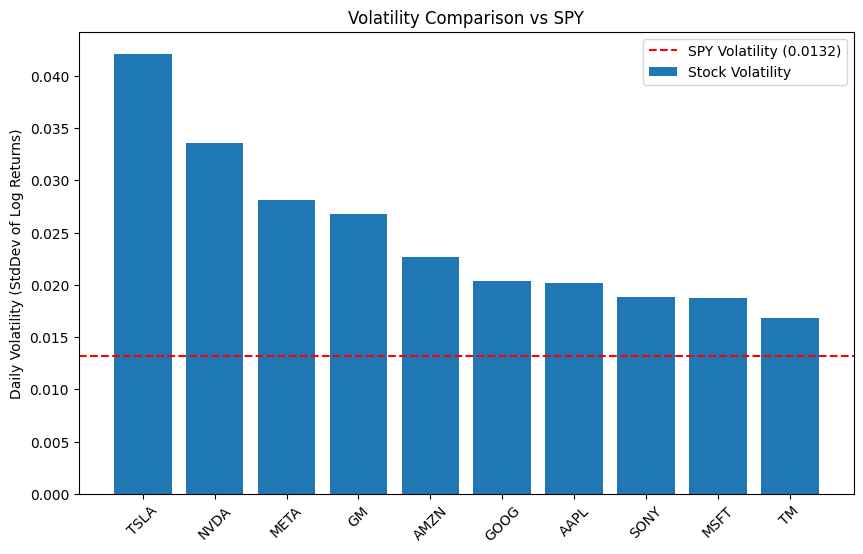

In [22]:
#Get SPY volatility as a plain float
spy_vol = float(spy_returns.std().iloc[0]) #Done in order to avoid having a warning

plt.figure(figsize=(10, 6))
plt.bar(summary_stats.index, summary_stats["StdDev"], label="Stock Volatility")
plt.axhline(
  y=spy_vol,
  color='red',
  linestyle='--',
  label=f"SPY Volatility ({spy_vol:.4f})"
)
plt.xticks(rotation=45)
plt.title("Volatility Comparison vs SPY")
plt.ylabel("Daily Volatility (StdDev of Log Returns)")
plt.legend()
plt.show()

Merton Jump Diffusion Model

In [32]:
def mjd_loglik(returns, dt, mu, sigma, lam, muJ, sigmaJ):
    #Log likelihood of Merton jump diffusion for a series of log returns
    returns = np.asarray(returns, dtype=float)
    lamdt = lam * dt
    max_n = max(40, int(10 + 5*lamdt))  #Truncate Poisson mixture
    ll = 0.0
    two_pi = 2.0 * pi

    for r in returns:
        pois = np.exp(-lamdt)  #P(N=0)
        mix_pdf = 0.0
        for n in range(max_n + 1):
            m = mu*dt + n*muJ
            v = sigma**2*dt + n*(sigmaJ**2)
            #Normal PDF
            mix_pdf += pois * (1.0 / np.sqrt(two_pi * v)) * np.exp(-(r - m)**2 / (2.0 * v))
            if n < max_n:
                #Update Poisson weight for next n
                pois = pois * (lamdt) / (n + 1)

        mix_pdf = max(mix_pdf, 1e-300)
        ll += np.log(mix_pdf)

    return ll


def fit_mjd_to_returns(returns, dt):
    returns = np.asarray(returns, dtype=float)

    mu0 = np.mean(returns) / dt
    sigma0 = np.std(returns) / np.sqrt(dt)

    init = np.array([
        mu0,                 # drift
        max(1e-4, sigma0),   # diffusion vol
        0.5,                 # jump intensity
        -0.02,               # avg jump size
        0.1                  # jump vol
    ], dtype=float)

    bounds = [
        (-np.inf, np.inf),   # mu
        (1e-6, np.inf),      # sigma
        (1e-6, 3.0),        # lam
        (-2.0, 2.0),         # muJ
        (1e-6, 5.0)          # sigmaJ
    ]

    def nll(theta):
        mu, sigma, lam, muJ, sigmaJ = theta
        base = -mjd_loglik(returns, dt, mu, sigma, lam, muJ, sigmaJ)
        penalty = 0.1 * lam #Have a penalty as well
        return base + penalty

    res = minimize(nll, init, method="L-BFGS-B", bounds=bounds)
    mu, sigma, lam, muJ, sigmaJ = res.x

    return {
        "mu": float(mu),
        "sigma": float(sigma),
        "lam": float(lam),
        "muJ": float(muJ),
        "sigmaJ": float(sigmaJ),
        "success": bool(res.success),
        "message": res.message,
        "nll": float(res.fun),
    }

#Run Calibration
dt = 1/252  #Daily data
mjd_results = {}

for ticker in log_returns.columns:
    ret = log_returns[ticker].values
    out = fit_mjd_to_returns(ret, dt)
    mjd_results[ticker] = out
    print(f"Fitted {ticker}: lambda={out['lam']:.3f}, muJ={out['muJ']:.3f}, sigmaJ={out['sigmaJ']:.3f}, success={out['success']}")

print()

#Do SPY too
spy_out = fit_mjd_to_returns(spy_returns.values, dt)
mjd_results["SPY"] = spy_out
print(f"Fitted SPY: lambda={spy_out['lam']:.3f}, muJ={spy_out['muJ']:.3f}, sigmaJ={spy_out['sigmaJ']:.3f}, success={spy_out['success']}")

Fitted AAPL: lambda=3.000, muJ=0.003, sigmaJ=0.073, success=True
Fitted AMZN: lambda=3.000, muJ=-0.005, sigmaJ=0.075, success=True
Fitted GM: lambda=3.000, muJ=-0.002, sigmaJ=0.093, success=True
Fitted GOOG: lambda=3.000, muJ=0.001, sigmaJ=0.067, success=True
Fitted META: lambda=3.000, muJ=-0.006, sigmaJ=0.121, success=True
Fitted MSFT: lambda=3.000, muJ=0.007, sigmaJ=0.067, success=True
Fitted NVDA: lambda=3.000, muJ=0.020, sigmaJ=0.112, success=True
Fitted SONY: lambda=3.000, muJ=-0.000, sigmaJ=0.061, success=True
Fitted TM: lambda=3.000, muJ=0.014, sigmaJ=0.058, success=True
Fitted TSLA: lambda=3.000, muJ=-0.012, sigmaJ=0.134, success=True

Fitted SPY: lambda=3.000, muJ=-0.012, sigmaJ=0.051, success=True


Volatility and Jump Analysis

,mu,sigma,lam,muJ,sigmaJ,success,empirical_vol
AAPL,0.2069,0.2691,3.0000,0.0030,0.0729,1.0000,0.0202
AMZN,0.1881,0.3108,3.0000,-0.0046,0.0752,1.0000,0.0226
GM,0.1250,0.3687,3.0000,-0.0015,0.0930,1.0000,0.0268
GOOG,0.2386,0.2799,3.0000,0.0007,0.0671,1.0000,0.0204
META,0.2214,0.3443,3.0000,-0.0063,0.1212,1.0000,0.0281
MSFT,0.1639,0.2484,3.0000,0.0065,0.0673,1.0000,0.0187
NVDA,0.5088,0.4797,3.0000,0.0199,0.1120,1.0000,0.0336
SONY,0.1269,0.2651,3.0000,-0.0003,0.0607,1.0000,0.0188
TM,0.0196,0.2316,3.0000,0.0136,0.0577,1.0000,0.0168
TSLA,0.5268,0.5915,3.0000,-0.0117,0.1340,1.0000,0.0421


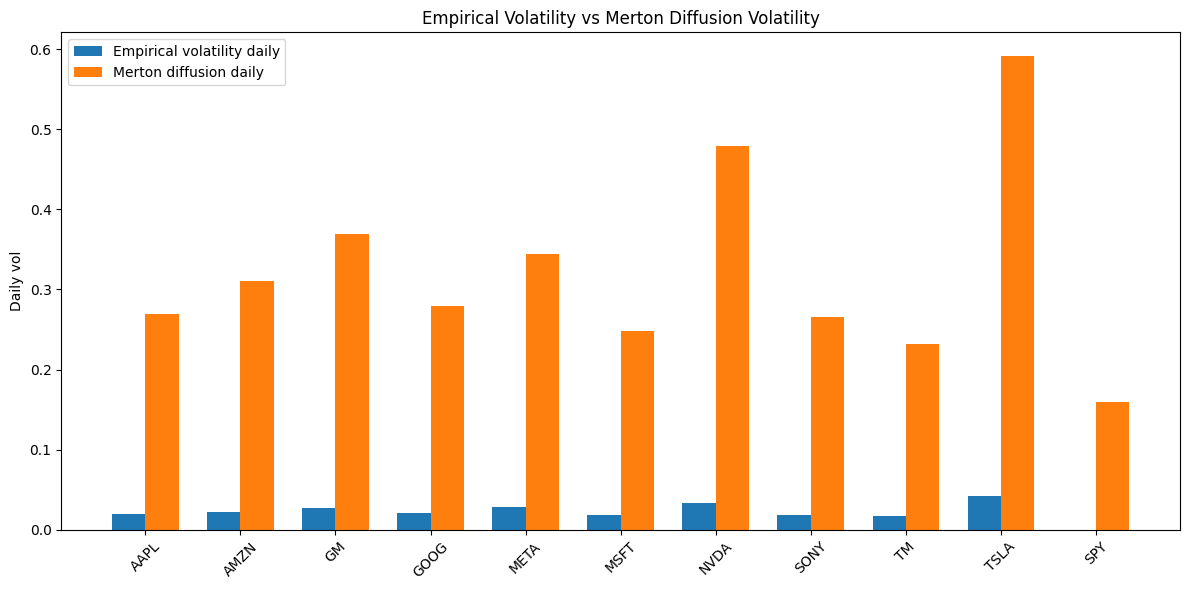

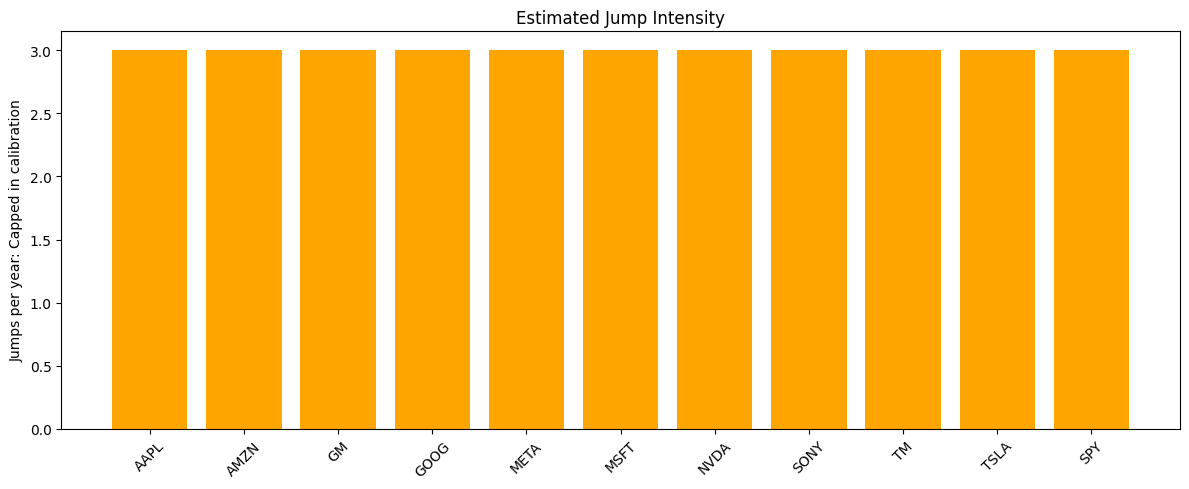

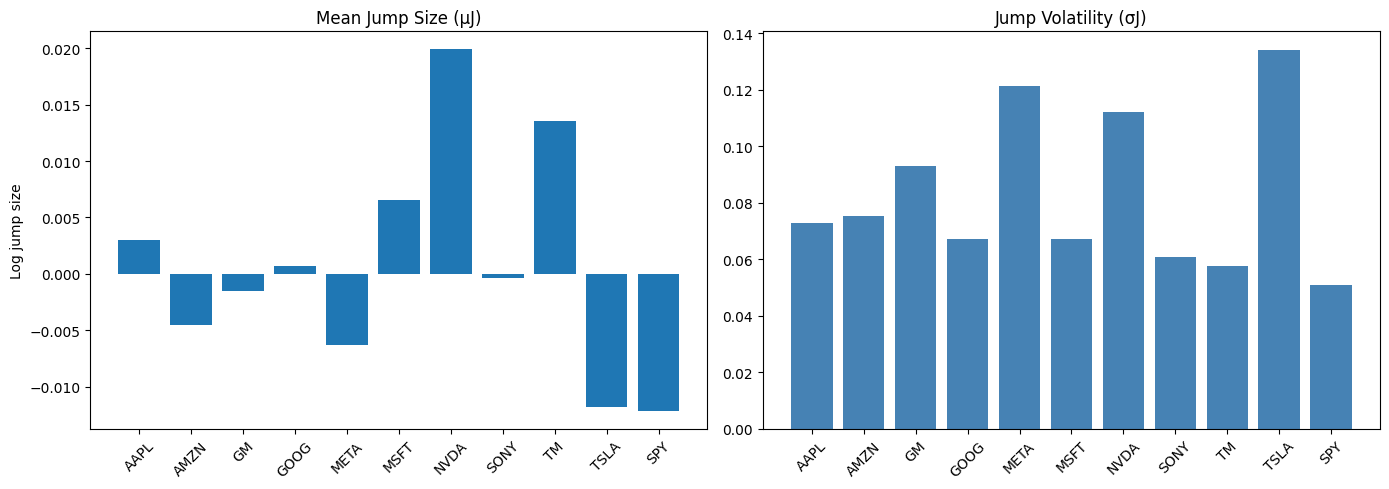

In [36]:
mjd_df = pd.DataFrame(mjd_results).T[["mu", "sigma", "lam", "muJ", "sigmaJ", "success"]]
empirical_volume = log_returns.std() #Add Empirical volume
mjd_df["empirical_vol"] = empirical_volume
mjd_df = mjd_df.sort_values("lam", ascending=False) #Sort by jump intensity
display(mjd_df.style.format("{:.4f}").background_gradient(cmap="viridis"))

plt.figure(figsize=(12, 6))

x = np.arange(len(mjd_df.index))
width = 0.35

plt.bar(x - width/2, mjd_df["empirical_vol"], width=width, label="Empirical volatility daily")
plt.bar(x + width/2, mjd_df["sigma"], width=width, label="Merton diffusion daily")

plt.xticks(x, mjd_df.index, rotation=45)
plt.title("Empirical Volatility vs Merton Diffusion Volatility")
plt.ylabel("Daily vol")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(mjd_df.index, mjd_df["lam"], color="orange")
plt.xticks(rotation=45)
plt.title("Estimated Jump Intensity")
plt.ylabel("Jumps per year: Capped in calibration")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14,5))

# mean jump size
ax[0].bar(mjd_df.index, mjd_df["muJ"])
ax[0].set_title("Mean Jump Size (μJ)")
ax[0].set_ylabel("Log jump size")
ax[0].tick_params(axis='x', rotation=45)

# jump volatility
ax[1].bar(mjd_df.index, mjd_df["sigmaJ"], color="steelblue")
ax[1].set_title("Jump Volatility (σJ)")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

SPY Parameters

In [37]:
print("SPY params:")
print(mjd_df.loc["SPY"][["sigma", "lam", "muJ", "sigmaJ", "empirical_vol"]]) #Done to use SPY Parameters as a control

SPY params:
sigma            0.159493
lam                   3.0
muJ             -0.012116
sigmaJ           0.051021
empirical_vol         NaN
Name: SPY, dtype: object


American Option Pricing under Merton Jump with TSLA

Using TSLA: S0=429.52, sigma=0.5915, lambda=3.000, muJ=-0.0117, sigmaJ=0.1340
American PUT under Merton (LSM): 56.4638
American PUT under BS (binomial): 427.4404


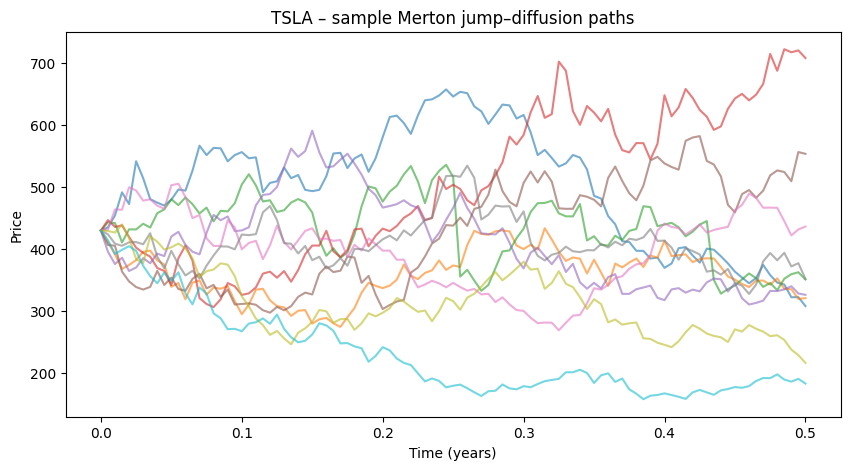

In [47]:
chosen = "TSLA"
S0 = my_data[chosen].iloc[-1]
r = 0.02
q = 0.0
T = 0.5
K = S0

mu_hat    = mjd_df.loc[chosen, "mu"]
sigma_hat = mjd_df.loc[chosen, "sigma"]
lam_hat   = mjd_df.loc[chosen, "lam"]
muJ_hat   = mjd_df.loc[chosen, "muJ"]
sigmaJ_hat= mjd_df.loc[chosen, "sigmaJ"]

print(f"Using {chosen}: S0={S0:.2f}, sigma={sigma_hat:.4f}, lambda={lam_hat:.3f}, muJ={muJ_hat:.4f}, sigmaJ={sigmaJ_hat:.4f}")

def simulate_mjd_paths(S0, r, q, sigma, lam, muJ, sigmaJ, T, n_steps, n_paths, seed=None):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0

    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0

    for t in range(1, n_steps + 1):
        Z = rng.standard_normal(n_paths)
        N = rng.poisson(lam * dt, size=n_paths)
        jump_term = np.where(
            N > 0,
            rng.normal(loc=N * muJ, scale=np.sqrt(N) * sigmaJ),
            0.0
        )
        drift = (r - q - lam * kappa - 0.5 * sigma**2) * dt
        diff  = sigma * np.sqrt(dt) * Z
        S[:, t] = S[:, t-1] * np.exp(drift + diff + jump_term)

    return S


def american_put_lsm(paths, K, r, T):
    n_paths, n_steps_plus = paths.shape
    n_steps = n_steps_plus - 1
    dt = T / n_steps
    disc = np.exp(-r * dt)

    #Payoff at maturity
    S_T = paths[:, -1]
    cashflows = np.maximum(K - S_T, 0.0)

    #Work backwards
    for t in range(n_steps - 1, 0, -1):
        S_t = paths[:, t]
        payoff = np.maximum(K - S_t, 0.0)

        itm = payoff > 1e-12
        if np.any(itm):
            X = S_t[itm]
            Y = cashflows[itm] * disc

            A = np.vstack([np.ones_like(X), X, X**2]).T
            coeffs, *_ = np.linalg.lstsq(A, Y, rcond=None)
            continuation = coeffs[0] + coeffs[1]*S_t + coeffs[2]*(S_t**2)
        else:
            continuation = np.zeros_like(S_t)

        #Decide to exercise or continue
        exercise = payoff > continuation
        #Update cashflows: exercise now or keep old
        cashflows = np.where(exercise, payoff, cashflows * disc)

    price = np.mean(cashflows) * disc
    return price

def american_put_binomial(S0, K, r, q, sigma_annual, T, steps=200):
    dt = T / steps
    u = np.exp(sigma_annual * np.sqrt(dt))
    d = 1 / u
    disc = np.exp(-r * dt)
    p = (np.exp((r - q) * dt) - d) / (u - d)

    #Stock price tree
    S = np.zeros((steps + 1, steps + 1))
    S[0, 0] = S0
    for i in range(1, steps + 1):
        S[i, 0] = S[i-1, 0] * u
        for j in range(1, i + 1):
            S[i, j] = S[i-1, j-1] * d

    #Option values at maturity
    V = np.maximum(K - S[steps, :steps+1], 0.0)

    #Backward Induction
    for i in range(steps - 1, -1, -1):
        V_hold = disc * (p * V[:i+1] + (1 - p) * V[1:i+2])
        V_ex   = np.maximum(K - S[i, :i+1], 0.0)
        V = np.maximum(V_hold, V_ex)

    return V[0]

n_paths = 5000
n_steps = 100

paths = simulate_mjd_paths(
    S0=S0,
    r=r,
    q=q,
    sigma=sigma_hat,
    lam=lam_hat,
    muJ=muJ_hat,
    sigmaJ=sigmaJ_hat,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=42
)

merton_american_put = american_put_lsm(paths, K, r, T)
bs_american_put     = american_put_binomial(S0, K, r, q, sigma_hat * np.sqrt(252), T, steps=200) #Rescale for daily

print(f"American PUT under Merton (LSM): {merton_american_put:.4f}")
print(f"American PUT under BS (binomial): {bs_american_put:.4f}")

#Visualize a few paths
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(np.linspace(0,T,n_steps+1), paths[i], alpha=0.6)
plt.title(f"{chosen} – sample Merton jump–diffusion paths")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()


American Option Pricing under Merton Jump with AAPL

Using AAPL: S0=268.47, sigma=0.2691, lambda=3.000, muJ=0.0030, sigmaJ=0.0729
American PUT under Merton (LSM): 15.7283
American PUT under BS (binomial): 231.2301


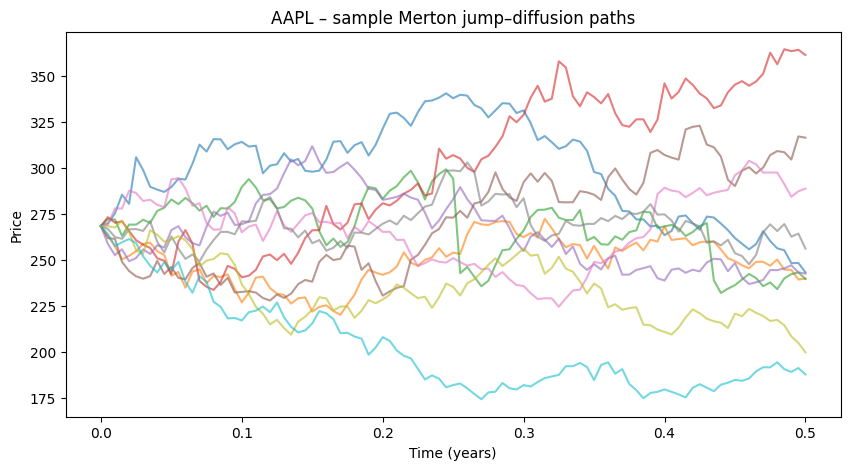

In [46]:
chosen = "AAPL"
S0 = my_data[chosen].iloc[-1]
r = 0.02
q = 0.0
T = 0.5
K = S0

mu_hat    = mjd_df.loc[chosen, "mu"]
sigma_hat = mjd_df.loc[chosen, "sigma"]
lam_hat   = mjd_df.loc[chosen, "lam"]
muJ_hat   = mjd_df.loc[chosen, "muJ"]
sigmaJ_hat= mjd_df.loc[chosen, "sigmaJ"]

print(f"Using {chosen}: S0={S0:.2f}, sigma={sigma_hat:.4f}, lambda={lam_hat:.3f}, muJ={muJ_hat:.4f}, sigmaJ={sigmaJ_hat:.4f}")

def simulate_mjd_paths(S0, r, q, sigma, lam, muJ, sigmaJ, T, n_steps, n_paths, seed=None):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0

    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0

    for t in range(1, n_steps + 1):
        Z = rng.standard_normal(n_paths)
        N = rng.poisson(lam * dt, size=n_paths)
        jump_term = np.where(
            N > 0,
            rng.normal(loc=N * muJ, scale=np.sqrt(N) * sigmaJ),
            0.0
        )
        drift = (r - q - lam * kappa - 0.5 * sigma**2) * dt
        diff  = sigma * np.sqrt(dt) * Z
        S[:, t] = S[:, t-1] * np.exp(drift + diff + jump_term)

    return S


def american_put_lsm(paths, K, r, T):
    n_paths, n_steps_plus = paths.shape
    n_steps = n_steps_plus - 1
    dt = T / n_steps
    disc = np.exp(-r * dt)

    #Payoff at maturity
    S_T = paths[:, -1]
    cashflows = np.maximum(K - S_T, 0.0)

    #Work backwards
    for t in range(n_steps - 1, 0, -1):
        S_t = paths[:, t]
        payoff = np.maximum(K - S_t, 0.0)

        itm = payoff > 1e-12
        if np.any(itm):
            X = S_t[itm]
            Y = cashflows[itm] * disc

            A = np.vstack([np.ones_like(X), X, X**2]).T
            coeffs, *_ = np.linalg.lstsq(A, Y, rcond=None)
            continuation = coeffs[0] + coeffs[1]*S_t + coeffs[2]*(S_t**2)
        else:
            continuation = np.zeros_like(S_t)

        #Decide to exercise or continue
        exercise = payoff > continuation
        #Update cashflows: exercise now or keep old
        cashflows = np.where(exercise, payoff, cashflows * disc)

    price = np.mean(cashflows) * disc
    return price

def american_put_binomial(S0, K, r, q, sigma_annual, T, steps=200):
    dt = T / steps
    u = np.exp(sigma_annual * np.sqrt(dt))
    d = 1 / u
    disc = np.exp(-r * dt)
    p = (np.exp((r - q) * dt) - d) / (u - d)

    #Stock price tree
    S = np.zeros((steps + 1, steps + 1))
    S[0, 0] = S0
    for i in range(1, steps + 1):
        S[i, 0] = S[i-1, 0] * u
        for j in range(1, i + 1):
            S[i, j] = S[i-1, j-1] * d

    #Option values at maturity
    V = np.maximum(K - S[steps, :steps+1], 0.0)

    #Backward Induction
    for i in range(steps - 1, -1, -1):
        V_hold = disc * (p * V[:i+1] + (1 - p) * V[1:i+2])
        V_ex   = np.maximum(K - S[i, :i+1], 0.0)
        V = np.maximum(V_hold, V_ex)

    return V[0]

n_paths = 5000
n_steps = 100

paths = simulate_mjd_paths(
    S0=S0,
    r=r,
    q=q,
    sigma=sigma_hat,
    lam=lam_hat,
    muJ=muJ_hat,
    sigmaJ=sigmaJ_hat,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    seed=42
)

merton_american_put = american_put_lsm(paths, K, r, T)
bs_american_put     = american_put_binomial(S0, K, r, q, sigma_hat * np.sqrt(252), T, steps=200) #Rescale for daily

print(f"American PUT under Merton (LSM): {merton_american_put:.4f}")
print(f"American PUT under BS (binomial): {bs_american_put:.4f}")

#Visualize a few paths
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(np.linspace(0,T,n_steps+1), paths[i], alpha=0.6)
plt.title(f"{chosen} – sample Merton jump–diffusion paths")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()


Delta Hedging Simulation with TSLA

Hedging test on TSLA: S0=429.52, daily sigma=0.5915, lambda=3.000
Hedging P&L: mean=90.9125, std=286.2257


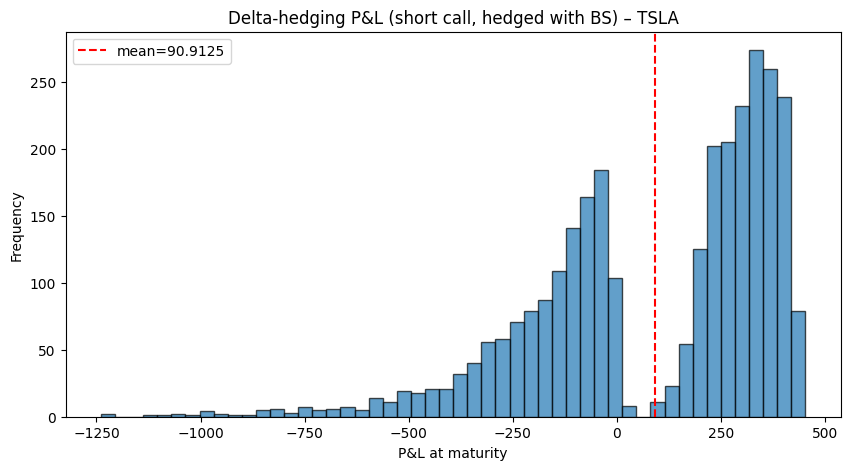

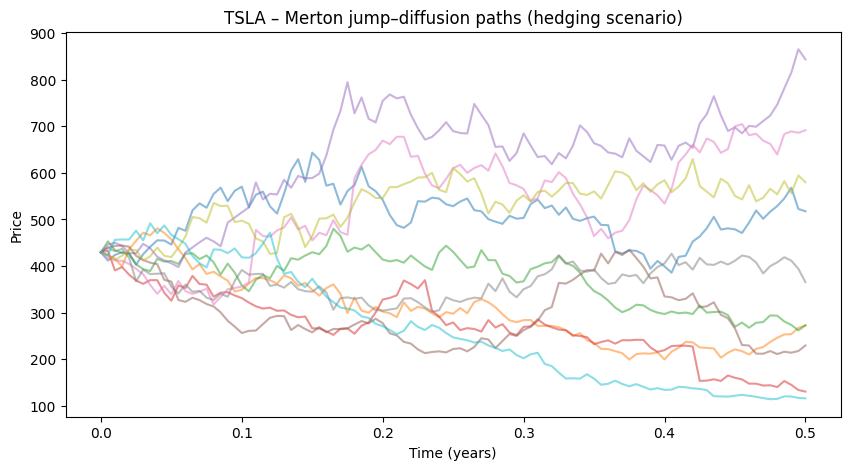

In [48]:
def bs_call_price_delta(S, K, r, q, sigma_annual, tau):
    if tau <= 0:
        price = np.maximum(S - K, 0.0)
        delta = np.where(S > K, 1.0, 0.0)
        return price, delta

    vol_sqrt = sigma_annual * np.sqrt(tau)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma_annual**2) * tau) / vol_sqrt
    d2 = d1 - vol_sqrt

    disc_r = np.exp(-r * tau)
    disc_q = np.exp(-q * tau)

    price = disc_q * S * norm.cdf(d1) - disc_r * K * norm.cdf(d2)
    delta = disc_q * norm.cdf(d1)
    return price, delta

chosen = "TSLA"
S0 = my_data[chosen].iloc[-1]
r = 0.02
q = 0.0
T = 0.5
K = S0

mu_hat    = mjd_df.loc[chosen, "mu"]
sigma_hat = mjd_df.loc[chosen, "sigma"]
lam_hat   = mjd_df.loc[chosen, "lam"]
muJ_hat   = mjd_df.loc[chosen, "muJ"]
sigmaJ_hat= mjd_df.loc[chosen, "sigmaJ"]

sigma_annual = sigma_hat * np.sqrt(252)

print(f"Hedging test on {chosen}: S0={S0:.2f}, daily sigma={sigma_hat:.4f}, lambda={lam_hat:.3f}")

def simulate_delta_hedging_mjd(
    S0, r, q, sigma_daily, lam, muJ, sigmaJ,
    K, T, n_steps, n_paths,
    sigma_annual_for_hedge,
    seed=None
):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    times = np.linspace(0, T, n_steps+1)

    #Simulate Paths
    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    S = np.zeros((n_paths, n_steps+1))
    S[:, 0] = S0

    for t in range(1, n_steps+1):
        Z = rng.standard_normal(n_paths)
        N = rng.poisson(lam * dt, size=n_paths)
        jump_term = np.where(
            N > 0,
            rng.normal(loc=N * muJ, scale=np.sqrt(N) * sigmaJ),
            0.0
        )
        drift = (r - q - lam*kappa - 0.5 * sigma_daily**2) * dt
        diff  = sigma_daily * np.sqrt(dt) * Z
        S[:, t] = S[:, t-1] * np.exp(drift + diff + jump_term)

    pnl = np.zeros(n_paths)

    price0, delta0 = bs_call_price_delta(S0, K, r, q, sigma_annual_for_hedge, T)
    cash = np.full(n_paths, price0) - delta0 * S[:, 0]
    delta_prev = np.full(n_paths, delta0)

    for t in range(1, n_steps+1):
        tau = T - times[t]  #Time to maturity
        #Accrue interest on cash
        cash = cash * np.exp(r * dt)

        #Compute new delta from BS
        price_t, delta_t = bs_call_price_delta(S[:, t], K, r, q, sigma_annual_for_hedge, tau)

        #Rebalance with buying and selling
        cash = cash - (delta_t - delta_prev) * S[:, t]

        #Update delta
        delta_prev = delta_t

    payoff = np.maximum(S[:, -1] - K, 0.0)
    pnl = cash - payoff

    return pnl, S

#Running the experiment
n_paths = 3000
n_steps = 100

pnl, paths = simulate_delta_hedging_mjd(
    S0=S0,
    r=r,
    q=q,
    sigma_daily=sigma_hat,
    lam=lam_hat,
    muJ=muJ_hat,
    sigmaJ=sigmaJ_hat,
    K=K,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    sigma_annual_for_hedge=sigma_annual,
    seed=123
)

print(f"Hedging P&L: mean={pnl.mean():.4f}, std={pnl.std():.4f}")

plt.figure(figsize=(10,5))
plt.hist(pnl, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(pnl.mean(), color='red', linestyle='--', label=f"mean={pnl.mean():.4f}")
plt.title(f"Delta-hedging P&L (short call, hedged with BS) – {chosen}")
plt.xlabel("P&L at maturity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#Show a few Merton Jump Diffusion Paths
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(np.linspace(0, T, n_steps+1), paths[i], alpha=0.5)
plt.title(f"{chosen} – Merton jump–diffusion paths (hedging scenario)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()

Delta Hedging Simulation with AAPL

Hedging test on AAPL: S0=268.47, daily sigma=0.2691, lambda=3.000
Hedging P&L: mean=55.9592, std=151.9779


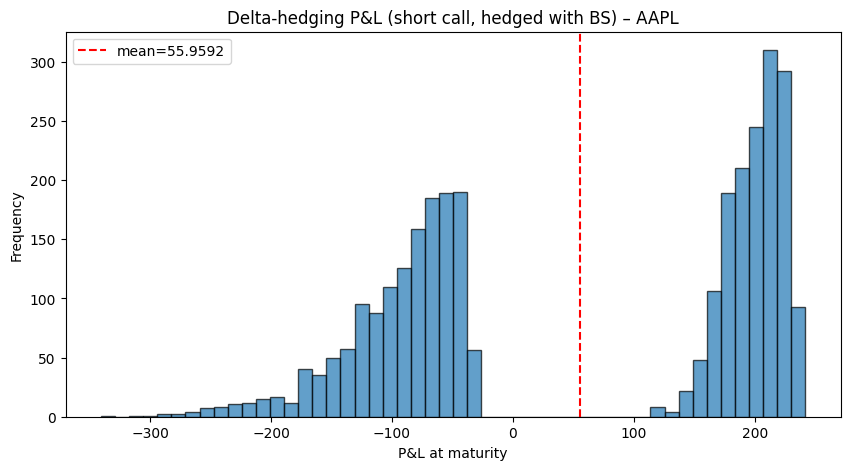

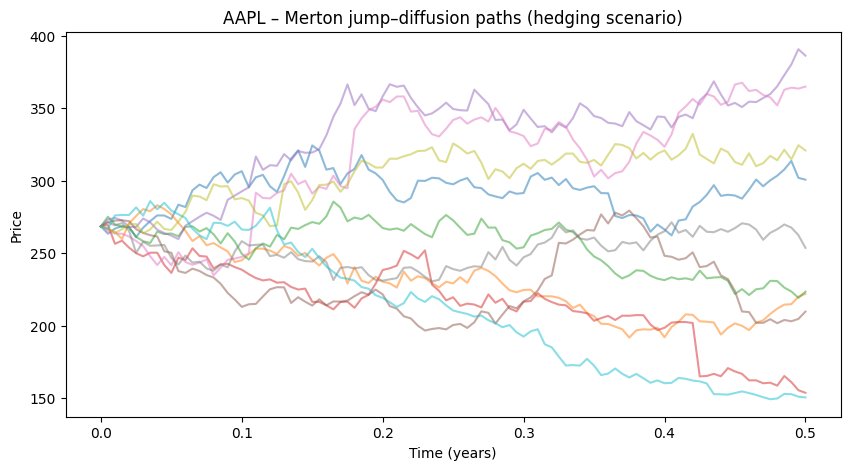

In [49]:
def bs_call_price_delta(S, K, r, q, sigma_annual, tau):
    if tau <= 0:
        price = np.maximum(S - K, 0.0)
        delta = np.where(S > K, 1.0, 0.0)
        return price, delta

    vol_sqrt = sigma_annual * np.sqrt(tau)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma_annual**2) * tau) / vol_sqrt
    d2 = d1 - vol_sqrt

    disc_r = np.exp(-r * tau)
    disc_q = np.exp(-q * tau)

    price = disc_q * S * norm.cdf(d1) - disc_r * K * norm.cdf(d2)
    delta = disc_q * norm.cdf(d1)
    return price, delta

chosen = "AAPL"
S0 = my_data[chosen].iloc[-1]
r = 0.02
q = 0.0
T = 0.5
K = S0

mu_hat    = mjd_df.loc[chosen, "mu"]
sigma_hat = mjd_df.loc[chosen, "sigma"]
lam_hat   = mjd_df.loc[chosen, "lam"]
muJ_hat   = mjd_df.loc[chosen, "muJ"]
sigmaJ_hat= mjd_df.loc[chosen, "sigmaJ"]

sigma_annual = sigma_hat * np.sqrt(252)

print(f"Hedging test on {chosen}: S0={S0:.2f}, daily sigma={sigma_hat:.4f}, lambda={lam_hat:.3f}")

def simulate_delta_hedging_mjd(
    S0, r, q, sigma_daily, lam, muJ, sigmaJ,
    K, T, n_steps, n_paths,
    sigma_annual_for_hedge,
    seed=None
):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    times = np.linspace(0, T, n_steps+1)

    #Simulate Paths
    kappa = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    S = np.zeros((n_paths, n_steps+1))
    S[:, 0] = S0

    for t in range(1, n_steps+1):
        Z = rng.standard_normal(n_paths)
        N = rng.poisson(lam * dt, size=n_paths)
        jump_term = np.where(
            N > 0,
            rng.normal(loc=N * muJ, scale=np.sqrt(N) * sigmaJ),
            0.0
        )
        drift = (r - q - lam*kappa - 0.5 * sigma_daily**2) * dt
        diff  = sigma_daily * np.sqrt(dt) * Z
        S[:, t] = S[:, t-1] * np.exp(drift + diff + jump_term)

    pnl = np.zeros(n_paths)

    price0, delta0 = bs_call_price_delta(S0, K, r, q, sigma_annual_for_hedge, T)
    cash = np.full(n_paths, price0) - delta0 * S[:, 0]
    delta_prev = np.full(n_paths, delta0)

    for t in range(1, n_steps+1):
        tau = T - times[t]  #Time to maturity
        #Accrue interest on cash
        cash = cash * np.exp(r * dt)

        #Compute new delta from BS
        price_t, delta_t = bs_call_price_delta(S[:, t], K, r, q, sigma_annual_for_hedge, tau)

        #Rebalance with buying and selling
        cash = cash - (delta_t - delta_prev) * S[:, t]

        #Update delta
        delta_prev = delta_t

    payoff = np.maximum(S[:, -1] - K, 0.0)
    pnl = cash - payoff

    return pnl, S

#Running the experiment
n_paths = 3000
n_steps = 100

pnl, paths = simulate_delta_hedging_mjd(
    S0=S0,
    r=r,
    q=q,
    sigma_daily=sigma_hat,
    lam=lam_hat,
    muJ=muJ_hat,
    sigmaJ=sigmaJ_hat,
    K=K,
    T=T,
    n_steps=n_steps,
    n_paths=n_paths,
    sigma_annual_for_hedge=sigma_annual,
    seed=123
)

print(f"Hedging P&L: mean={pnl.mean():.4f}, std={pnl.std():.4f}")

plt.figure(figsize=(10,5))
plt.hist(pnl, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(pnl.mean(), color='red', linestyle='--', label=f"mean={pnl.mean():.4f}")
plt.title(f"Delta-hedging P&L (short call, hedged with BS) – {chosen}")
plt.xlabel("P&L at maturity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#Show a few Merton Jump Diffusion Paths
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(np.linspace(0, T, n_steps+1), paths[i], alpha=0.5)
plt.title(f"{chosen} – Merton jump–diffusion paths (hedging scenario)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()

Short summary

,Ticker,lambda,muJ,sigmaJ,Hedge_PnL_Mean,Hedge_PnL_Std
0,AAPL,3.0000,0.0030,0.0729,59.6489,151.2733
1,TSLA,3.0000,-0.0117,0.1340,96.1543,280.1203
2,NVDA,3.0000,0.0199,0.1120,50.8532,115.7952
3,GOOG,3.0000,0.0007,0.0671,65.7768,157.6233
4,META,3.0000,-0.0063,0.1212,162.2981,365.4368


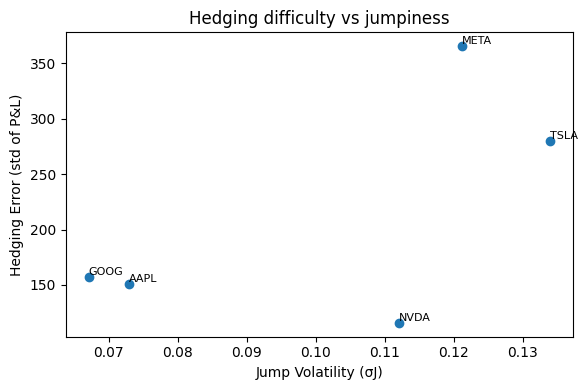

In [51]:
tickers_to_check = ["AAPL", "TSLA", "NVDA", "GOOG", "META", "SPY"]
results = []

for tk in tickers_to_check:
    if tk not in mjd_df.index or tk not in my_data.columns:
        continue

    S0 = my_data[tk].iloc[-1]
    lam   = mjd_df.loc[tk, "lam"]
    muJ   = mjd_df.loc[tk, "muJ"]
    sigmaJ= mjd_df.loc[tk, "sigmaJ"]
    sigma_daily = mjd_df.loc[tk, "sigma"]
    sigma_annual = sigma_daily * np.sqrt(252)

    pnl, _ = simulate_delta_hedging_mjd(
        S0=S0,
        r=r,
        q=q,
        sigma_daily=sigma_daily,
        lam=lam,
        muJ=muJ,
        sigmaJ=sigmaJ,
        K=S0,
        T=T,
        n_steps=100,
        n_paths=1500,  #Smaller for summary
        sigma_annual_for_hedge=sigma_annual,
        seed=123
    )

    results.append({
        "Ticker": tk,
        "lambda": lam,
        "muJ": muJ,
        "sigmaJ": sigmaJ,
        "Hedge_PnL_Mean": pnl.mean(),
        "Hedge_PnL_Std": pnl.std()
    })

summary_df = pd.DataFrame(results)

num_cols = ["lambda", "muJ", "sigmaJ", "Hedge_PnL_Mean", "Hedge_PnL_Std"]
display(summary_df.style.format({col: "{:.4f}" for col in num_cols}))

#Visual displaying jump volatility versus Hedging Error
plt.figure(figsize=(6,4))
plt.scatter(summary_df["sigmaJ"], summary_df["Hedge_PnL_Std"])
for _, row in summary_df.iterrows():
    plt.text(row["sigmaJ"], row["Hedge_PnL_Std"], row["Ticker"], fontsize=8, ha='left', va='bottom')
plt.xlabel("Jump Volatility (σJ)")
plt.ylabel("Hedging Error (std of P&L)")
plt.title("Hedging difficulty vs jumpiness")
plt.tight_layout()
plt.show()